# Calculate EOFs using the PCA module

In [32]:
# import modules
import pandas as pd
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pylab as plt
import re

total_variance = 0.975
# Set up PCA such that enough components are calculated to explain at least the "total_variance"
pca = PCA(n_components=total_variance)

First we load the anomaly file created with CDO. Don't forget to run create_eofs_cdo.sh before you do this step.

In [33]:
cdo_xr = xr.open_dataset("../data/speeds/cdo_speed_anomalies.nc")
cdo_speed = cdo_xr.variables["velsurf_mag"]
nt , ny, nx = cdo_speed.shape
cdo_speeds = cdo_speed.values.reshape(nt, ny * nx)


Second we load the raw files and create anomalies ourselves. Be careful to honor nans and removed them afterwards to get the same result as CDO.


In [34]:
from glob import glob
s_files = glob("../data/speeds/velsurf_mag_gris_g1800m_v3a_id_*_0_100.nc")
nt = len(s_files)

# open first file to get the dimensions
vxr0 = xr.open_dataset(s_files[0])
speed = vxr0.variables["velsurf_mag"].values
, ny, nx = speed.shape
vxr0.close()

m_speeds = np.zeros((nt, ny * nx))

# Go through all files and don't forget to extract the experiment id
ids = []
for k, s_file in enumerate(s_files):
    vxr = xr.open_dataset(s_file)
    ids.append(re.search("id_(.+?)_0", s_file).group(1))
    m_speeds[k, ::] = vxr.variables["velsurf_mag"].values.flatten()
    vxr.close()

m_speeds -= np.nanmean(m_speeds, axis=0)
m_speeds = np.nan_to_num(m_speeds, 0)

<ipython-input-34-041718486cb0>:21: RuntimeWarning: Mean of empty slice
  m_speeds -= np.nanmean(m_speeds, axis=0)


Now run the PCA (fit to speeds)

In [35]:
cdo_pca = pca.fit(cdo_speeds)
m_pca = pca.fit(m_speeds)

Number of components needed to explain the total_variance:

In [36]:
print(len(cdo_pca.explained_variance_))
print(len(m_pca.explained_variance_))

5
5


Let's check that we explain at least the total_variance:

In [37]:
print(np.sum(a_pca.explained_variance_ratio_))
print(np.sum(m_pca.explained_variance_ratio_))

0.9799100844375694
0.9799100844375694


Well, looks like we indeed explain the requested total_variance. Great.

## Eigenvalues

In the parlange of the PCA module,

`explained_variance_` are the `eigenvectors`
and
`components_` are the `eigenvalues` $e_j(t)$.

In [38]:
cdo_eigenvalues = cdo_pca.explained_variance_
m_eigenvalues = m_pca.explained_variance_

Check the eigenvalues are the same for both methods:

In [39]:
print(cdo_eigenvalues - m_eigenvalues)

[0. 0. 0. 0. 0.]


Eigenvalues from CDO:

In [40]:
cdo_eval = np.array([
  3.698529e+10,
  7.92243e+09,
  6.240835e+09,
  1.705714e+09,
  7.179356e+08])

## Eigenvectors

In [41]:
cdo_eigenvectors = cdo_pca.components_
m_eigenvectors = m_pca.components_

Check the eigenvectors are the same:

In [42]:
np.max(cdo_eigenvectors - m_eigenvectors)


0.0

## Coefficients

Calculate the coefficients $o_j(t)$, which are the dot product of the eigen vectors with the anomaly matrix according to
\begin{equation}
o_j(t) = \sum_{x=i}^p z(t,x) e_j(x)
\end{equation}

In [43]:
cdo_coefficients = np.dot(cdo_eigenvectors, cdo_speeds.T)
m_coefficients = np.dot(m_eigenvectors, m_speeds.T)

The first five coefficients for the first eigen value is

In [44]:
print(cdo_coefficients.T[:5,0])
print(m_coefficients.T[:5,0])

[ 58180.6374309  430363.68455289 -89169.70962596 -93773.19104501
 -89415.02713017]
[-93773.19096404 -89169.70952314 430363.68534422 -55070.55013972
 -89185.43680256]


The coefficients are the same but the order is different.
Again we can compare this to CDO's eofcoeff operator:

In [30]:
cdo_coeff = np.array([
  58180.64,
  430363.7,
  -89169.71,
  -93773.19])

While they are not exactly the same, they seem close enough.

Put coefficients in DataFrame and save to CSV.

In [31]:
df = pd.DataFrame(data=a_coefficients.T[:,:], index=ids)
print(df.head())
df.to_csv("speed_coefficients.csv", index_label="id")

                0              1              2              3             4
21   58180.637431   47077.478878   -9278.486192  168460.763809 -41942.438666
20  430363.684553 -138844.637007  279795.773333   -3976.601346    -71.920887
14  -89169.709626  -22211.107518   -8041.260852  -17025.771089 -13869.671679
4   -93773.191045  -21023.778469   -6003.881325  -17529.006562  -4083.537179
5   -89415.027130  -22736.280302   -8408.252338  -16980.369106 -13628.064645


So why are `m_speeds` and `a_speeds` different but their eigenvalues and vectors are not?

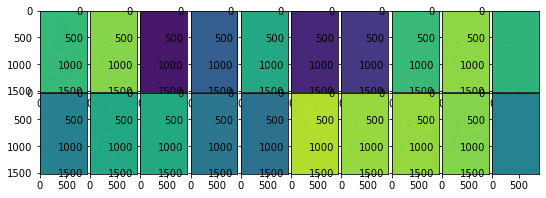

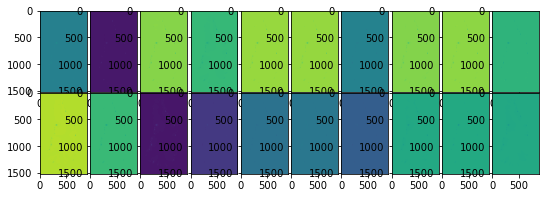

In [17]:
fig, axes = plt.subplots(2,10,figsize=(9,3),
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(m_speeds[i].reshape(ny,nx))

fig, axes = plt.subplots(2,10,figsize=(9,3),
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(a_speeds[i].reshape(ny,nx))

Well it looks like that `cdo mergetime` orders the fields differently than `glob` picks them up.

In [45]:
m_eigenvalues

array([3.88345583e+10, 8.31855224e+09, 6.55287629e+09, 1.79100016e+09,
       7.53832317e+08])